In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

In [3]:
import os

class CircuitComparer:
    def __init__(self, dirname, before, after):
        self.fname_before = os.path.join(dirname, before)
        self.fname_after = os.path.join(dirname, after)
        self.name = before[:-7]
        self.has_run = False
    
    def __str__(self):
        return "CircuitComparer({}, {})".format(self.name, str(self.has_run))

    def __repr__(self):
        return str(self)
    
    def run(self):
        if self.has_run: return True
        try: 
            c = zx.Circuit.from_quipper_file(self.fname_after).to_basic_gates()
            self.t_opt = c.tcount()
            self.qubits = c.qubits
            c = zx.Circuit.from_quipper_file(self.fname_before).to_basic_gates()
        except TypeError: return False
        self.gatecount = len(c.gates)
        self.t_before = c.tcount()
        g = c.to_graph()
        while True:
            zx.simplify.full_reduce(g)
            m = zx.rules.match_gadgets_phasepoly(g)
            if not m: break
            zx.rules.apply_gadget_phasepoly(g, m)
        self.t_after = zx.tcount(g)
        self.has_run = True
        del c, g
        return True
    
    def pretty(self):
        if not self.has_run:
            success = self.run()
        else: success = True
        if not success: 
            return self.name + "    -"
        s = self.name.ljust(20) + str(self.qubits).rjust(7)
        s += str(self.gatecount).rjust(8) + str(self.t_before).rjust(7) + str(self.t_opt).rjust(9) + str(self.t_after).rjust(7)
        return s

In [4]:

dirs = [r'..\circuits\Arithmetic_and_Toffoli', r'..\circuits\QFT_and_Adders']
beforefiles = []
afterfiles = []
for d in dirs:
    for f in os.listdir(d):
        if not os.path.isfile(os.path.join(d,f)): continue
        if f.find('before') != -1:
            beforefiles.append((f,d))
        else: afterfiles.append((f,d))

circuits = []
for f, d in beforefiles:
    n = f[:-7]
    for f2,d2 in afterfiles:
        if d!=d2: continue
        #n = f2.replace("_after_heavy","")
        if f2.startswith(n):
            c = CircuitComparer(d, f, f2)
            circuits.append(c)
            break
#circuits[:30]

In [7]:
print("Circuit".ljust(20), "qubits", "G-count", "T-before", "T-kitchen", "T-us")
for c in circuits:
    if c.run():
        print(c.pretty())

Circuit              qubits G-count T-before T-kitchen T-us
adder_8                  24    1014    399      215    145
barenco_tof_10           19     514    224      100     63
barenco_tof_3             5      66     28       16     14
barenco_tof_4             7     130     56       28     21
barenco_tof_5             9     194     84       40     38
csla_mux_3_original      15     190     70       64     46
csum_mux_9_corrected     30     448    196       84     84
gf2^E10_mult             30    1709    700      410    410
gf2^E16_mult             48    4397   1792     1040    968
gf2^E4_mult              12     275    112       68     64
gf2^E5_mult              15     429    175      115     92
gf2^E6_mult              18     617    252      150    140
gf2^E7_mult              21     839    343      217    182
gf2^E8_mult              24    1109    448      264    247
gf2^E9_mult              27    1385    567      351    311
mod5_4                    5      71     28       16    

28
14
True


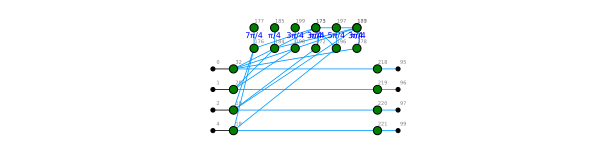

In [73]:
c = [c for c in circuits if c.name == 'barenco_tof_3'][0]
g = zx.Circuit.from_quipper_file(c.fname_before).to_graph()
print(zx.tcount(g))
g2 = zx.Circuit.from_quipper_file(c.fname_after).to_graph()
#print(zx.tcount(g), zx.tcount(g2))
#zx.full_reduce(g, quiet=True)
#g.normalise()
#g.compose(g2.adjoint())
while True:
    zx.full_reduce(g, quiet=True)
    m = zx.rules.match_gadgets_phasepoly(g)
    if not m: break
    else: 
        #print("Found {:d} phasepoly matches".format(len(m)))
        #print(" ".join(str((len(b)-8)*2+1) for a,b in m))
        #print(*[str(a) for a,b in m])
        #print("T-count before: ", zx.tcount(g))
        zx.rules.apply_gadget_phasepoly(g, m)
        #print("T-count after: ", zx.tcount(g))
g.normalise()
print(zx.tcount(g))
try: c2 = zx.extract.streaming_extract(g)
except: pass
zx.simplify.id_simp(g,quiet=True)
g.remove_vertices([3,98])
g.inputs.remove(3)
g.outputs.remove(98)
g.set_edge_type((18,99),1)
g.normalise()
print(zx.is_unitary(g))
zx.draw(g, labels=True)
#print(zx.compare_tensors(g.to_tensor(),g2.to_tensor()))
# zx.draw(g,figsize=(20,3))

#c3 = c2.split_phase_gates()
#print(zx.compare_tensors(c2.to_tensor(),g2.to_tensor()))
#print(c3.to_qasm())
#print(len(c2.gates), c2.tcount())
#zx.draw(c3.to_graph())

#zx.compare_tensors(g.to_tensor(),t)

In [64]:
leftrow = 1
left = [v for v in g.vertices() if g.row(v) == leftrow]
special_nodes = {}
for v in g.vertices():
    if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
        n = list(g.neighbours(v))[0]
        special_nodes[n] = v

right = set()
for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>leftrow)
gadgets = right.intersection(special_nodes)
gadgets
#print(w1, w2, w3, zx.extract.cut_rank(g, list(right.difference({w1,w2, w3})), left))
#zx.extract.cut_rank(g, right, left)

{172, 176, 178, 184, 196, 198}

In [ ]:
g2 = g.copy()
zx.simplify.id_simp(g2,quiet=True)
g3 = zx.quantomatic.edit_graph(g3)

Opening Quantomatic...


In [69]:
t = g.to_tensor()
t/t.flatten()[0]

array([[[[[[[[ 1.+0.j,  0.+0.j],
             [ 0.+0.j, -1.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 1.-0.j,  0.+0.j],
             [ 0.+0.j,  0.+1.j]]]],



          [[[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]]]],




         [[[[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]]],



          [[[[-1.+0.j,  0.+0.j],
             [ 0.+0.j,  1.-0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.